In [622]:
%store -r train_mod 
%store -r test_mod

In [623]:
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87264 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              87263 non-null  object 
 1   brand                 87264 non-null  object 
 2   color                 87264 non-null  object 
 3   fuelType              87264 non-null  object 
 4   modelDate             87263 non-null  float64
 5   name                  87263 non-null  object 
 6   numberOfDoors         87263 non-null  float64
 7   productionDate        87264 non-null  int64  
 8   vehicleConfiguration  87263 non-null  object 
 9   vehicleTransmission   87263 non-null  object 
 10  engineDisplacement    87263 non-null  object 
 11  enginePower           87263 non-null  float64
 12  description           84031 non-null  object 
 13  mileage               87264 non-null  int64  
 14  Комплектация          87264 non-null  object 
 15  Привод             

In [624]:
test_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [625]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

In [626]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]
Numpy        : 1.22.3


##### Определение общих и различающихся столбцов в TRAIN и TEST

In [627]:
#Общие столбцы
common_columns = set(test_mod.columns).intersection(train_mod.columns)

#Только в TEST
test_only_columns = set(test_mod.columns).difference(train_mod.columns)

#Только в TRAIN
train_only_columns = set(train_mod.columns).difference(test_mod.columns)

In [628]:
#Датафрейм со сравнением типов данных
index_list = test_mod[common_columns].dtypes.index.to_list()
test_list = test_mod[common_columns].dtypes.values.tolist()
train_list = train_mod[common_columns].dtypes.values.tolist()

dict_comparison = {
    'title': index_list,
    'test_type': test_list,
    'train_type': train_list
}

comparison = pd.DataFrame(dict_comparison)
comparison.sort_values('title')

C:\Temp\ipykernel_7588\3330007078.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index_list = test_mod[common_columns].dtypes.index.to_list()
C:\Temp\ipykernel_7588\3330007078.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_list = test_mod[common_columns].dtypes.values.tolist()
C:\Temp\ipykernel_7588\3330007078.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_list = train_mod[common_columns].dtypes.values.tolist()


,title,test_type,train_type
5,bodyType,object,object
8,brand,object,object
3,color,object,object
2,description,object,object
13,engineDisplacement,object,object
10,enginePower,object,float64
1,fuelType,object,object
12,mileage,int64,int64
17,modelDate,int64,float64
7,name,object,object


Как можно видеть, формат данных в части столбцов с одинаковыми названиями не совпадает. Также необходимо исследовать содержаимое ячеек.

In [629]:
#Создадим пустой список, в который будем вносить имена столбцов, подлежащих удалению. 
#будем заполнять его по ходу первичного анализа.
columns_to_drop = []

##### Бренды в TRAIN и TEST

In [630]:
display(train_mod.brand.unique())
print('Всего в TRAIN',len(train_mod.brand.unique()),'брендов.',sep=' ')

array(['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GREAT_WALL', 'LAND_ROVER', 'MERCEDES', 'SSANG_YONG'], dtype=object)

Всего в TRAIN 36 брендов.


In [631]:
display(test_mod.brand.unique())
print('Всего в TEST',len(test_mod.brand.unique()),'брендов.',sep=' ')

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

Всего в TEST 12 брендов.


## Распределение брендов в TEST

Text(0.5, 1.0, 'TEST brands')

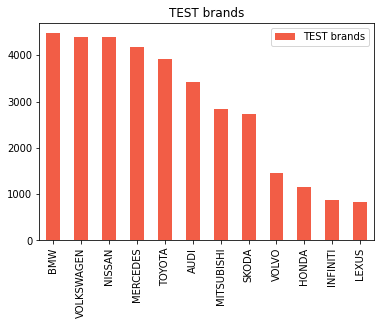

In [632]:
test_mod['brand'].value_counts().plot(kind='bar', color = '#F25D46', label='TEST brands')
plt.legend()
plt.title('TEST brands')

## Распределение брендов в TRAIN

Text(0.5, 1.0, 'TRAIN brands')

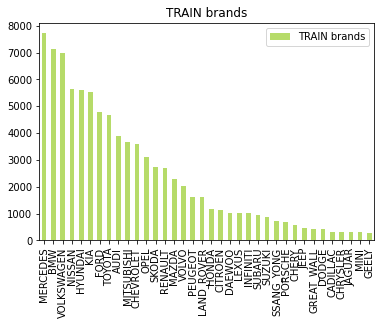

In [633]:
train_mod['brand'].value_counts().plot(kind='bar', color = '#B6DB69', label='TRAIN brands')
plt.legend()
plt.title('TRAIN brands')

Мы видим, что распеределение брендов, представленных только во TEST, схоже с TRAIN. 

Поэтому для базовой модели ML отсутствующие модели можно удалить, однако для Staking и ансамблей можно попробовать объединить присутствующие и удаленные модели в классы для извлечения новых признаков.

##### Сравнение содержание ячеек TRAIN и TEST, приведение к единому формату

In [634]:
#Датафрейм со сравнением типов данных
index_list = test_mod[common_columns].dtypes.index.to_list()
test_list = test_mod[common_columns].dtypes.values.tolist()
train_list = train_mod[common_columns].dtypes.values.tolist()

dict_comparison = {
    'title': index_list,
    'test_type': test_list,
    'train_type': train_list
}

comparison = pd.DataFrame(dict_comparison)
comparison.sort_values('title')

C:\Temp\ipykernel_7588\3330007078.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index_list = test_mod[common_columns].dtypes.index.to_list()
C:\Temp\ipykernel_7588\3330007078.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_list = test_mod[common_columns].dtypes.values.tolist()
C:\Temp\ipykernel_7588\3330007078.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_list = train_mod[common_columns].dtypes.values.tolist()


,title,test_type,train_type
5,bodyType,object,object
8,brand,object,object
3,color,object,object
2,description,object,object
13,engineDisplacement,object,object
10,enginePower,object,float64
1,fuelType,object,object
12,mileage,int64,int64
17,modelDate,int64,float64
7,name,object,object


In [635]:
#Функция для просмотра и сравнения типов данных в столбцах
def type_comparison(column):
    print('TEST')
    display(test_mod[column].sample(5))
    print('TRAIN')
    display(train_mod[column].sample(5))  

## bodyType

In [636]:
column = 'bodyType'
type_comparison(column)

TEST


16358    хэтчбек 5 дв.
6327             седан
16229            седан
9349     хэтчбек 5 дв.
10028          лифтбек
Name: bodyType, dtype: object

TRAIN


1768                 Седан
44597    Внедорожник 5 дв.
78039      Универсал 5 дв.
61105              Лифтбек
67370    Внедорожник 5 дв.
Name: bodyType, dtype: object

Необходимо привести данные к единому формату и убрать из значений кол-во дверей

## color

In [637]:
column = 'color'
type_comparison(column)

TEST


32896        бежевый
29877        зелёный
32952    серебристый
10359        бежевый
26726        бежевый
Name: color, dtype: object

TRAIN


63694    040001
64900    97948F
57683    200204
75610    97948F
11779    EE1D19
Name: color, dtype: object

Здесь также требуется приведение к единому формату

## description

In [638]:
column = 'description'
type_comparison(column)

TEST


2747     • Автомобиль проверен по 110 пунктам\n• Автокр...
18656    Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» ...
32019    Комфорт: 9. Безопасность: 5. Обзор: 2. Салон: ...
1708     Безопасность: 1. Салон: 2. Комфорт: 3. Защита ...
19325    Автомобиль в прекрасном состоянии всё работает...
Name: description, dtype: object

TRAIN


68999    Тойота Центр Лосиный Остров - дилерский центр ...
25762    ТО пройдено 16.09.2019 . ВСЕ ВОПРОСЫ ПО ТЕЛЕФО...
87489    Авто радует, как и расход. Все работает (пневм...
58228    Воспользуйтесь системами TRADE-IN и кредитован...
25064    коцки по кузову, на ходу. коробка переключаетс...
Name: description, dtype: object

Пока неясно можно ли как-либо использовать этот столбец

## engineDisplacement

In [639]:
column = 'engineDisplacement'
type_comparison(column)

TEST


21880    3.5 LTR
30628    3.0 LTR
1952     1.4 LTR
19899    2.8 LTR
27776    2.0 LTR
Name: engineDisplacement, dtype: object

TRAIN


53335     1.4
7674     650i
3533     2.0d
74171     1.2
70096     1.6
Name: engineDisplacement, dtype: object

Необходимо привести данные к единому формату

In [640]:
#Преобразование
def GetEngineDisplacement(x):
    row = str(x)
    engine = re.findall('\d\.\d', row)
    if engine == []:
        return None
    return float(engine[0])

train_mod['engineDisplacement'] = train_mod['engineDisplacement'].map(GetEngineDisplacement)
test_mod['engineDisplacement'] = test_mod['engineDisplacement'].map(GetEngineDisplacement)

In [641]:
column = 'engineDisplacement'
type_comparison(column)

TEST


24128    2.5
26998    1.6
15669    3.5
23275    2.0
33722    3.0
Name: engineDisplacement, dtype: float64

TRAIN


3622     4.1
30453    2.5
78707    2.0
86671    NaN
73536    1.6
Name: engineDisplacement, dtype: float64

После преобразования в столбцах появились пропуски

In [642]:
test_mod[test_mod['engineDisplacement'].isna()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
5241,внедорожник 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/e_tron/110...,белый,NaN,Audi e-tron Prestige quattro от Moscow Tesla C...,NaN,408 N12,"{""asr"":true,""esp"":true,""usb"":true,""e-adjustmen...",электро,...,ALLROAD_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,1 год и 3 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен
7992,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11010431...,синий,NaN,"Атомобиль из Германии,без пробега по РФ.\nНа г...",NaN,170 N12,NaN,электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8252,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11012780...,серый,NaN,"Пробег 54000 км, запас хода на зарядке 130 км+...",NaN,170 N12,"{""park-assist-f"":true,""park-assist-r"":true}",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,1 месяц,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8350,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11002716...,белый,"{""id"":""21624597"",""name"":""i3 120 Ah"",""available...","Автомобиль в наличии Москве , с ПТС , производ...",NaN,170 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8684,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11011745...,чёрный,NaN,BMW I 3 REX\nфевраль 2017 года выпуска.\nПриоб...,NaN,170 N12,"{""cruise-control"":true,""glonass"":true,""navigat...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8722,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11000973...,голубой,NaN,\nПрибыло из Америки в августе 2020 года. Полн...,NaN,170 N12,NaN,электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8917,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11008715...,бежевый,NaN,-Состояние нового автомобиля .\n-Carfax вся ис...,NaN,170 N12,"{""glonass"":true,""roof-rails"":true}",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
10817,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11012664...,серый,NaN,Продаю BMW I3 +REX .\n\nПолноценный электромоб...,NaN,170 N12,NaN,электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
10936,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/10996733...,чёрный,NaN,Автомобиль BMW i3 (полностью электрический )за...,NaN,170 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
11043,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/10993761...,серый,NaN,Состояние нового автомобиля . \nФото ИМЕННО ЭТ...,NaN,170 N12,"{""glonass"":true,""airbag-driver"":true,""aux"":tru...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,8 месяцев,Оригинал,задний,Левый,Не требует ремонта,Растаможен


In [643]:
train_mod[train_mod['engineDisplacement'].isna()]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
45,Седан,AUDI,040001,бензин,1990.0,S4 2.2 AT (230 л.с.) 4WD,4.0,1992,SEDAN AUTOMATIC S4,AUTOMATIC,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,220000.0,2020-07-09T06:57:21Z,NaN,100
345,Седан,AUDI,040001,бензин,2012.0,ultra 1.4 AMT (150 л.с.),4.0,2016,SEDAN ROBOT ultra,ROBOT,...,LEFT,NaN,2.0,ORIGINAL,True,NaN,1254090.0,2020-09-05T16:01:05Z,NaN,A3
383,Седан,AUDI,FAFBFB,бензин,2012.0,ultra 1.4 AMT (150 л.с.),4.0,2015,SEDAN ROBOT ultra,ROBOT,...,LEFT,NaN,1.0,ORIGINAL,True,NaN,870000.0,2020-07-28T11:55:47Z,NaN,A3
658,Универсал 5 дв.,AUDI,040001,дизель,2004.0,8V 2.0d MT (140 л.с.),5.0,2005,WAGON_5_DOORS MECHANICAL 8V,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2020, 'month': 2}",380000.0,2020-09-08T19:06:10Z,NaN,A4
671,Универсал 5 дв.,AUDI,040001,дизель,2004.0,8V 2.0d CVT (140 л.с.),5.0,2007,WAGON_5_DOORS VARIATOR 8V,VARIATOR,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,395000.0,2020-07-26T20:05:31Z,NaN,A4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89238,Внедорожник 5 дв.,SSANG_YONG,CACECB,дизель,2007.0,6-speed 2.0d AT (141 л.с.) 4WD,5.0,2010,ALLROAD_5_DOORS AUTOMATIC 6-speed,AUTOMATIC,...,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2018, 'month': 3}",455000.0,2020-05-26T14:21:34Z,NaN,KYRON
89239,Внедорожник 5 дв.,SSANG_YONG,040001,бензин,2007.0,6-speed 2.3 AT (150 л.с.) 4WD,5.0,2009,ALLROAD_5_DOORS AUTOMATIC 6-speed,AUTOMATIC,...,LEFT,NaN,2.0,ORIGINAL,True,NaN,525000.0,2020-05-31T06:33:06Z,NaN,KYRON
89242,Внедорожник 5 дв.,SSANG_YONG,97948F,дизель,2007.0,6-speed 2.0d AT (141 л.с.) 4WD,5.0,2012,ALLROAD_5_DOORS AUTOMATIC 6-speed,AUTOMATIC,...,LEFT,NaN,2.0,ORIGINAL,True,NaN,650000.0,2020-02-26T13:40:39Z,NaN,KYRON
89247,Пикап Двойная кабина Sports,SSANG_YONG,CACECB,дизель,1998.0,Sports 2.9d MT (120 л.с.) 4WD,4.0,2006,PICKUP_TWO MECHANICAL Sports,MECHANICAL,...,LEFT,NaN,1.0,ORIGINAL,True,NaN,385000.0,2020-08-30T12:58:53Z,NaN,MUSSO


Возможно, эти пропуски мы сможем заполнить, взяв информацию из столбца 'name'

In [644]:
test_mod[test_mod['engineDisplacement'].isna()]['name']

5241     55 Electro AT (301 кВт) 4WD
7992            Electro AT (126 кВт)
8252            Electro AT (126 кВт)
8350            Electro AT (126 кВт)
8684       94Ah Electro AT (126 кВт)
8722            Electro AT (126 кВт)
8917       94Ah Electro AT (126 кВт)
10817           Electro AT (126 кВт)
10936           Electro AT (126 кВт)
11043      94Ah Electro AT (126 кВт)
11302            Electro AT (81 кВт)
11682           Electro AT (111 кВт)
11714           Electro AT (111 кВт)
11719            Electro AT (81 кВт)
11754            Electro AT (81 кВт)
11878            Electro AT (81 кВт)
11974            Electro AT (81 кВт)
12072            Electro AT (81 кВт)
12085            Electro AT (81 кВт)
12100      30kWh Electro AT (81 кВт)
12250            Electro AT (81 кВт)
12287            Electro AT (81 кВт)
12334            Electro AT (81 кВт)
12466      30kWh Electro AT (81 кВт)
12481            Electro AT (81 кВт)
12558            Electro AT (81 кВт)
12582      30kWh Electro AT (81 кВт)
1

Очевидно что в TEST объём двигателя отсутствует исключительно у электромобилей. Что вполне логично. Стоит заполнить пропуски нолями

In [645]:
test_mod['engineDisplacement'].fillna(0, inplace = True)

In [646]:
train_mod[train_mod['engineDisplacement'].isna()]['name']

45             S4 2.2 AT (230 л.с.) 4WD
345            ultra 1.4 AMT (150 л.с.)
383            ultra 1.4 AMT (150 л.с.)
658               8V 2.0d MT (140 л.с.)
671              8V 2.0d CVT (140 л.с.)
                      ...              
89238    6-speed 2.0d AT (141 л.с.) 4WD
89239     6-speed 2.3 AT (150 л.с.) 4WD
89242    6-speed 2.0d AT (141 л.с.) 4WD
89247     Sports 2.9d MT (120 л.с.) 4WD
89252     Sports 2.9d AT (120 л.с.) 4WD
Name: name, Length: 20387, dtype: object

В TRAIN ситуация совсем иная. С этим ещё предстоит разобраться.

## enginePower

In [647]:
column = 'enginePower'
type_comparison(column)

TEST


6339     190 N12
2192     122 N12
14740    211 N12
27541    160 N12
28614    220 N12
Name: enginePower, dtype: object

TRAIN


43177     98.0
56759    500.0
55026     75.0
52403    115.0
81510    156.0
Name: enginePower, dtype: float64

Необходимо привести данные к единому формату

In [648]:
#Преобразование
train_mod.enginePower = train_mod.enginePower.convert_dtypes(int)
test_mod["enginePower"] = test_mod["enginePower"].apply(lambda x : (int)(x.split(' ')[0]))

In [649]:
column = 'enginePower'
type_comparison(column)

TEST


18535    517
24196    152
2645     160
34292    181
3144     333
Name: enginePower, dtype: int64

TRAIN


51875    167
19925    100
88589    136
29706    123
37923    150
Name: enginePower, dtype: Int64

Проверим не образовались ли пропуски в этом столбце

In [650]:
test_mod[test_mod['enginePower'].isna()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня


In [651]:
train_mod[train_mod['enginePower'].isna()]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
24624,NaN,HONDA,CACECB,универсал,NaN,NaN,NaN,1989,NaN,NaN,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,120000.0,2020-04-10T16:07:57Z,NaN,CIVIC


Образовался один пропуск. Строка с этим пропуском в целом содержит мало данных и должна быть удалена

In [652]:
train_mod.drop(24624, inplace = True)

## fuelType

In [653]:
column = 'fuelType'
type_comparison(column)

TEST


1143     бензин
27853    бензин
14983    бензин
26891    дизель
15184    бензин
Name: fuelType, dtype: object

TRAIN


54120    бензин
6975     дизель
80624    бензин
4967     бензин
64093    бензин
Name: fuelType, dtype: object

In [654]:
train_mod.fuelType.unique() 

array(['бензин', 'дизель', 'электро', 'гибрид', 'газ'], dtype=object)

In [655]:
test_mod.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

Никаких преобразований не требуется

## mileage

In [656]:
column = 'mileage'
type_comparison(column)

TEST


8559     156000
22954      1300
22978    172000
9616     140000
10519    144000
Name: mileage, dtype: int64

TRAIN


41402    123862
71036    154000
25154    100000
60720     60000
61352    135000
Name: mileage, dtype: int64

Имеет смысл разделить всё значения на 1000 и округлить - сотни километров пробега не имеют значения при оценке автомобиля.  
Так мы уменьшим кол-во уникальных значений в столбце.

In [657]:
test_mod['mileage'] = test_mod['mileage'].apply(lambda x: round(x/1000))
train_mod['mileage'] = train_mod['mileage'].apply(lambda x: round(x/1000))

## modelDate

In [658]:
column = 'modelDate'
type_comparison(column)

TEST


1509     2013
10664    2008
20905    1995
28523    2010
33383    1995
Name: modelDate, dtype: int64

TRAIN


69078    2008.0
39548    2006.0
46255    2012.0
33669    2013.0
6755     2009.0
Name: modelDate, dtype: float64

Приводим к единому формату

In [659]:
#Преобразование
train_mod.modelDate = train_mod.modelDate.convert_dtypes(int) #astype('int')

In [660]:
column = 'modelDate'
type_comparison(column)

TEST


32031    2009
34542    2006
3418     2005
9627     2015
18589    2012
Name: modelDate, dtype: int64

TRAIN


55247    2016
16527    2008
1343     2011
34977    2004
34897    2017
Name: modelDate, dtype: Int64

## name

In [661]:
column = 'name'
type_comparison(column)

TEST


9696      4.4 AT (555 л.с.) 4WD
31138         1.6 AT (110 л.с.)
19164    4.5d AT (235 л.с.) 4WD
2828     2.5 AMT (400 л.с.) 4WD
28468      0.7 AT (64 л.с.) 4WD
Name: name, dtype: object

TRAIN


62454         1.8 MT (152 л.с.)
3496     2.0 AMT (249 л.с.) 4WD
42471     2.5d AT (85 л.с.) 4WD
41143     2.3 AT (238 л.с.) 4WD
76773        2.0 AMT (145 л.с.)
Name: name, dtype: object

В этом столбце есть информация об объёме двигателя. Её можно использовать для заполнения пропусков в столбце 'engineDisplacement'.  
Потом этот столбец будет не нужен.

In [662]:
columns_to_drop.append('name')

In [663]:
#Эта функция вытащит объём двигателя из столбца 'name'
def find_disp(string):
    string = str(string)
    res = re.findall('\d\.\d', string)
    if len(res) !=0:
        return float(res[0])
    else:
        return 0

In [664]:
#Заменим все значения в 'engineDisplacement'
train_mod['engineDisplacement'] = train_mod['name'].apply(find_disp)

In [665]:
#Проверим результат
train_mod[train_mod['engineDisplacement'] == 0]['fuelType'].unique()

array(['электро'], dtype=object)

In [666]:
train_mod[train_mod['engineDisplacement'].isna()]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model


Пропусков нет, а у электромобилей объём равен 0

## numberOfDoors

In [667]:
column = 'numberOfDoors'
type_comparison(column)

TEST


4732     4
19548    4
11714    5
23386    5
8535     5
Name: numberOfDoors, dtype: int64

TRAIN


51204    5.0
62320    5.0
81343    4.0
51427    5.0
61874    5.0
Name: numberOfDoors, dtype: float64

Приводим к единому формату

In [668]:
#Преобразование
train_mod.numberOfDoors = train_mod.numberOfDoors.convert_dtypes(int)

## productionDate

In [669]:
column = 'productionDate'
type_comparison(column)

TEST


18819    2003
26652    2011
18682    2017
3798     2008
12262    2015
Name: productionDate, dtype: int64

TRAIN


85066    2015
53523    2007
85204    2020
53110    2011
47850    2010
Name: productionDate, dtype: int64

Не требует преобразований

## vehicleConfiguration

In [670]:
column = 'vehicleConfiguration'
type_comparison(column)

TEST


27522    ALLROAD_5_DOORS MECHANICAL 3.2
18518     ALLROAD_5_DOORS AUTOMATIC 5.5
32335               SEDAN AUTOMATIC 1.6
30408                   SEDAN ROBOT 1.6
21663       WAGON_5_DOORS AUTOMATIC 2.0
Name: vehicleConfiguration, dtype: object

TRAIN


19763                SEDAN AUTOMATIC 1.5
55542    HATCHBACK_5_DOORS AUTOMATIC 1.6
63397        WAGON_5_DOORS AUTOMATIC 2.0
83474        WAGON_5_DOORS AUTOMATIC 320
49670               MINIVAN VARIATOR 2.0
Name: vehicleConfiguration, dtype: object

Этот столбец тоже можно использовать для заполнения пропусков в столбце 'engineDisplacement'.  
После чего он также должен быть удалён.

In [671]:
columns_to_drop.append('vehicleConfiguration')

## vehicleTransmission

In [672]:
column = 'vehicleTransmission'
type_comparison(column)

TEST


5        роботизированная
22831      автоматическая
26400      автоматическая
20528      автоматическая
7460         механическая
Name: vehicleTransmission, dtype: object

TRAIN


29492     AUTOMATIC
1574       VARIATOR
19182    MECHANICAL
21338     AUTOMATIC
14019     AUTOMATIC
Name: vehicleTransmission, dtype: object

К единому формату

In [673]:
#Преобразование
train_mod.vehicleTransmission.unique()

array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR'], dtype=object)

In [674]:
test_mod.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [675]:
test_mod = test_mod.replace({'vehicleTransmission':
                            {'автоматическая': 'AUTOMATIC',
                            'вариатор': 'VARIATOR',
                            'механическая': 'MECHANICAL',
                            'роботизированная': 'ROBOT'}})

## Владельцы

# !!!Вот эту часть нужно как-то оформить красиво и доступно!!!

In [676]:
column = 'Владельцы'
type_comparison(column)

TEST


16446    3 или более
33104    3 или более
23507    2 владельца
12679    2 владельца
17940     1 владелец
Name: Владельцы, dtype: object

TRAIN


25985    2.0
18510    3.0
48482    1.0
62126    2.0
83549    3.0
Name: Владельцы, dtype: float64

In [677]:
test_mod.Владельцы.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [678]:
train_mod.Владельцы.unique()

array([ 3.,  1.,  2., nan])

Приведём к единому формату

In [679]:
#Преобразование
train_mod.Владельцы = train_mod.Владельцы.convert_dtypes(int)

test_mod = test_mod.replace({'Владельцы':
                            {'1\xa0владелец': 1,
                            '2\xa0владельца': 2,
                            '3 или более': 3}})

Посчитаем % пропусков

In [680]:
col = 'Владельцы'

pct_missing_1 = np.mean(test_mod[col].isnull()) 
print('TEST')
print('{} - {}%'.format(col, round(pct_missing_1*100)))
pct_missing_2 = np.mean(train_mod[col].isnull()) 
print('TRAIN')
print('{} - {}%'.format(col, round(pct_missing_2*100)))

TEST
Владельцы - 0%
TRAIN
Владельцы - 14%


Видим пропуски в TRAIN. Возможно, их удастся как-нибудь заполнить.  
Кол-во владельцев может быть связано с пробегом и годом выпуска автомобиля. Проверим

In [681]:
train_mod[train_mod['Владельцы'].isna()]['mileage'].unique()

array([0], dtype=int64)

In [682]:
train_mod[train_mod['Владельцы'].isna()]['productionDate'].unique()

array([2020, 2019, 2018, 2017], dtype=int64)

Пропуски есть только у автомобилей с нулевым пробегом, однако, судя по годам выпуска, не все они являлись новыми.

In [683]:
train_mod[train_mod['Владельцы'].isna()].query('productionDate == 2017')

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
35008,Седан,KIA,97948F,бензин,2015,5.0 AT (424 л.с.),4,2017,SEDAN AUTOMATIC 5.0,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,3829900.0,2018-03-16T10:33:04Z,NaN,QUORIS


In [684]:
train_mod[train_mod['Владельцы'].isna()].query('productionDate == 2018')

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
1680,Седан,AUDI,FAFBFB,бензин,2018,55 TFSI 3.0 AMT (340 л.с.) 4WD,4,2018,SEDAN ROBOT 55,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,4770000.0,2020-09-02T14:32:49Z,NaN,A6
1749,Седан,AUDI,FAFBFB,бензин,2018,55 TFSI 3.0 AMT (340 л.с.) 4WD,4,2018,SEDAN ROBOT 55,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,4600000.0,2020-08-05T14:37:05Z,NaN,A6
1823,Седан,AUDI,FAFBFB,бензин,2018,55 TFSI 3.0 AMT (340 л.с.) 4WD,4,2018,SEDAN ROBOT 55,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,4600000.0,2020-07-03T19:52:20Z,NaN,A6
2636,Седан Long,AUDI,040001,бензин,2017,60 TFSI Long 4.0 AT (460 л.с.) 4WD,4,2018,SEDAN AUTOMATIC 60,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,8222323.0,2020-09-02T16:29:19Z,NaN,A8
2681,Седан Long,AUDI,040001,бензин,2017,60 TFSI Long 4.0 AT (460 л.с.) 4WD,4,2018,SEDAN AUTOMATIC 60,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,8222323.0,2020-09-02T14:01:12Z,NaN,A8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86887,Седан,MERCEDES,040001,бензин,2017,600 6.0 AT (530 л.с.),4,2018,SEDAN AUTOMATIC 600,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,54057400.0,2020-08-17T15:52:18Z,NaN,S_CLASS_MAYBACH
86889,Седан,MERCEDES,CACECB,бензин,2017,650 6.0 AT (630 л.с.),4,2018,SEDAN AUTOMATIC 650,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,58089720.0,2020-02-13T19:49:18Z,NaN,S_CLASS_MAYBACH
86903,Седан,MERCEDES,97948F,бензин,2017,650 6.0 AT (630 л.с.),4,2018,SEDAN AUTOMATIC 650,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,54560408.0,2020-02-13T19:49:18Z,NaN,S_CLASS_MAYBACH
88015,Купе,MERCEDES,040001,бензин,2017,63 AMG 4.0 AT (612 л.с.) 4WD,2,2018,COUPE AUTOMATIC 63,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,15866765.0,2020-07-23T10:20:05Z,NaN,S_KLASSE_AMG


In [685]:
train_mod[train_mod['Владельцы'].isna()].query('productionDate == 2019')

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
1559,Седан,AUDI,FAFBFB,бензин,2018,45 TFSI 2.0 AMT (245 л.с.) 4WD,4,2019,SEDAN ROBOT 45,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,4247977.0,2019-11-07T19:32:44Z,NaN,A6
1757,Седан,AUDI,0000CC,бензин,2018,45 TFSI 2.0 AMT (245 л.с.) 4WD,4,2019,SEDAN ROBOT 45,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,3290000.0,2020-04-03T07:58:41Z,NaN,A6
1809,Седан,AUDI,FAFBFB,бензин,2018,45 TFSI 2.0 AMT (245 л.с.) 4WD,4,2019,SEDAN ROBOT 45,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,4247977.0,2019-11-07T20:07:20Z,NaN,A6
1842,Седан,AUDI,0000CC,бензин,2018,45 TFSI 2.0 AMT (245 л.с.) 4WD,4,2019,SEDAN ROBOT 45,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,3290000.0,2020-05-05T13:26:04Z,NaN,A6
1876,Седан,AUDI,040001,бензин,2018,45 TFSI 2.0 AMT (245 л.с.) 4WD,4,2019,SEDAN ROBOT 45,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,3290000.0,2020-04-03T07:58:41Z,NaN,A6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88052,Купе,MERCEDES,040001,бензин,2017,63 AMG 4.0 AT (612 л.с.) 4WD,2,2019,COUPE AUTOMATIC 63,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,14967400.0,2020-07-10T10:13:09Z,NaN,S_KLASSE_AMG
88170,Минивэн L,MERCEDES,0000CC,дизель,2014,250 d длинный 2.1d AT (190 л.с.) 4WD,5,2019,MINIVAN AUTOMATIC 250,AUTOMATIC,...,LEFT,NaN,<NA>,NaN,True,NaN,12990000.0,2020-05-29T12:49:19Z,NaN,V_KLASSE
88188,Минивэн L,MERCEDES,FAFBFB,дизель,2014,250 d длинный 2.1d AT (190 л.с.) 4WD,5,2019,MINIVAN AUTOMATIC 250,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,6490000.0,2020-05-18T19:41:20Z,NaN,V_KLASSE
88199,Минивэн L,MERCEDES,FAFBFB,дизель,2014,250 d длинный 2.1d AT (190 л.с.) 4WD,5,2019,MINIVAN AUTOMATIC 250,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,6490000.0,2020-04-06T13:16:50Z,NaN,V_KLASSE


In [686]:
train_mod[train_mod['Владельцы'].isna()].query('productionDate == 2020')

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
332,Седан,AUDI,97948F,бензин,2016,1.4 AMT (150 л.с.),4,2020,SEDAN ROBOT 1.4,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,1885400.0,2020-08-10T18:16:24Z,NaN,A3
333,Седан,AUDI,CACECB,бензин,2016,1.4 AMT (150 л.с.),4,2020,SEDAN ROBOT 1.4,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,1885400.0,2020-08-10T18:16:24Z,NaN,A3
336,Седан,AUDI,0000CC,бензин,2016,1.4 AMT (150 л.с.),4,2020,SEDAN ROBOT 1.4,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,1885400.0,2020-08-04T16:44:36Z,NaN,A3
339,Седан,AUDI,0000CC,бензин,2016,1.4 AMT (150 л.с.),4,2020,SEDAN ROBOT 1.4,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,2016000.0,2020-08-01T03:19:03Z,NaN,A3
342,Седан,AUDI,97948F,бензин,2016,1.4 AMT (150 л.с.),4,2020,SEDAN ROBOT 1.4,ROBOT,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,1946000.0,2020-08-01T03:19:03Z,NaN,A3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88272,Минивэн XL,MERCEDES,040001,дизель,2014,250 d экстра длинный 2.1d AT (190 л.с.) 4WD,5,2020,MINIVAN AUTOMATIC 250,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,7594200.0,2020-08-01T19:47:22Z,NaN,V_KLASSE
88273,Минивэн XL,MERCEDES,0000CC,дизель,2014,250 d экстра длинный 2.1d AT (190 л.с.) 4WD,5,2020,MINIVAN AUTOMATIC 250,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,7761400.0,2020-08-15T20:06:56Z,NaN,V_KLASSE
88275,Минивэн XL,MERCEDES,040001,дизель,2014,250 d экстра длинный 2.1d AT (190 л.с.) 4WD,5,2020,MINIVAN AUTOMATIC 250,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,7603640.0,2020-08-15T20:06:56Z,NaN,V_KLASSE
88278,Минивэн XL,MERCEDES,040001,дизель,2014,250 d экстра длинный 2.1d AT (190 л.с.) 4WD,5,2020,MINIVAN AUTOMATIC 250,AUTOMATIC,...,LEFT,NaN,<NA>,ORIGINAL,True,NaN,7633300.0,2020-08-15T20:06:56Z,NaN,V_KLASSE


Все эти автомобили - леворульные. Очевидно, они были привезены из Японии. Отсутствие пробега, вероятно, значит отсутствие пробега по России. Это говорит о том, что и владельцев в России у этих автомобилей не было. Следует заполнить пропуски нолями

## Владение

In [687]:
column = 'Владение' # перевести в дни, можно выкинуть
type_comparison(column)

TEST


34327                   NaN
31865    7 лет и 11 месяцев
10693                   NaN
28222      1 год и 2 месяца
31454      9 лет и 2 месяца
Name: Владение, dtype: object

TRAIN


40964    {'year': 2018, 'month': 11}
39229     {'year': 2014, 'month': 1}
57280                            NaN
63568     {'year': 2017, 'month': 8}
88126     {'year': 2019, 'month': 4}
Name: Владение, dtype: object

Посчитаем % пропусков

In [688]:
col = 'Владение'

pct_missing_1 = np.mean(test_mod[col].isnull()) 
print('TEST')
print('{} - {}%'.format(col, round(pct_missing_1*100)))
pct_missing_2 = np.mean(train_mod[col].isnull()) 
print('TRAIN')
print('{} - {}%'.format(col, round(pct_missing_2*100)))

TEST
Владение - 65%
TRAIN
Владение - 67%


Большой процент пропусков в TRAIN и TEST (около 70%), столбец можно удалить.

In [689]:
columns_to_drop.append('Владение')

## Привод

In [690]:
column = 'Привод'
type_comparison(column)

TEST


24735    передний
18940      задний
32395    передний
2871     передний
15935      полный
Name: Привод, dtype: object

TRAIN


68076    передний
28386    передний
8131       полный
76743    передний
72778    передний
Name: Привод, dtype: object

Оставляем как есть

## ПТС

In [691]:
column = 'ПТС'
type_comparison(column)

TEST


32354    Оригинал
11547    Оригинал
14261    Оригинал
5027     Дубликат
34423    Оригинал
Name: ПТС, dtype: object

TRAIN


28377    ORIGINAL
32356    ORIGINAL
80852    ORIGINAL
55693    ORIGINAL
51535    ORIGINAL
Name: ПТС, dtype: object

К единому формату

In [692]:
#Преобразование
test_mod = test_mod.replace({'ПТС':
                            {'Оригинал': 'ORIGINAL',
                            'Дубликат': 'DUPLICATE'}})

## Руль

In [693]:
column = 'Руль'
type_comparison(column)

TEST


2672     Левый
34558    Левый
20619    Левый
10875    Левый
6521     Левый
Name: Руль, dtype: object

TRAIN


46534     LEFT
79441     LEFT
54094     LEFT
41575    RIGHT
34527     LEFT
Name: Руль, dtype: object

Преобразуем также как предыдущий столбец

In [694]:
#Преобразование
test_mod = test_mod.replace({'Руль':
                            {'Левый': 'LEFT',
                            'Правый': 'RIGHT'}})

## Состояние

In [695]:
column = 'Состояние'
type_comparison(column)

TEST


24699    Не требует ремонта
21121    Не требует ремонта
11782    Не требует ремонта
13807    Не требует ремонта
12837    Не требует ремонта
Name: Состояние, dtype: object

TRAIN


52241   NaN
42304   NaN
35853   NaN
3066    NaN
45198   NaN
Name: Состояние, dtype: float64

In [696]:
test_mod.Состояние.unique()

array(['Не требует ремонта'], dtype=object)

In [697]:
train_mod.Состояние.unique()

array([nan])

В TEST только одно значение, в TRAIN - пустой столбец. СОСТОЯНИЕ можно удалить.

In [698]:
columns_to_drop.append('Состояние')

## Таможня

In [699]:
column = 'Таможня'
type_comparison(column)

TEST


15439    Растаможен
17090    Растаможен
7179     Растаможен
27860    Растаможен
2517     Растаможен
Name: Таможня, dtype: object

TRAIN


26036    True
1921     True
38588    True
24792    True
78531    True
Name: Таможня, dtype: bool

In [700]:
test_mod.Таможня.unique()

array(['Растаможен'], dtype=object)

In [701]:
train_mod.Таможня.unique()

array([ True])

В TRAIN и TEST во всех строках одинаковое значение, столбец ТАМОЖНЯ можно удалить.

In [702]:
columns_to_drop.append('Таможня')

### Столбцы ТОЛЬКО TEST

In [703]:
test_mod[test_only_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   model_name          34686 non-null  object
 1   parsing_unixtime    34686 non-null  int64 
 2   priceCurrency       34686 non-null  object
 3   equipment_dict      24690 non-null  object
 4   complectation_dict  6418 non-null   object
 5   model_info          34686 non-null  object
 6   car_url             34686 non-null  object
 7   sell_id             34686 non-null  int64 
 8   vendor              34686 non-null  object
 9   image               34686 non-null  object
 10  super_gen           34686 non-null  object
dtypes: int64(2), object(9)
memory usage: 3.2+ MB


C:\Temp\ipykernel_7588\1526034085.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_mod[test_only_columns].info()


## equipment_dict

In [704]:
#Процент пропусков
#Процент пропусков
col = 'equipment_dict'
missing = np.mean(test_mod[col].isnull()) 
print('{} - {}%'.format(col, round(missing*100)))

equipment_dict - 29%


In [705]:
test_mod.equipment_dict[938]

'{"engine-proof":true,"tinted-glass":true,"esp":true,"airbag-driver":true,"aux":true,"isofix":true,"usb":true,"electro-window-front":true,"hcc":true,"audiopreparation":true,"heated-wash-system":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"seat-transformation":true,"wheel-power":true,"lock":true,"fabric-seats":true,"electro-mirrors":true,"steel-wheels":true,"rain-sensor":true,"airbag-side":true,"mirrors-heat":true,"driver-seat-updown":true,"condition":true,"led-lights":true,"abs":true,"front-seats-heat":true,"wheel-configuration1":true,"immo":true,"12v-socket":true,"15-inch-wheels":true}'

Данные содержат описание комплектации.  
Однако, подобных данных нет в TRAIN и этот столбец не принесёт нам никакой пользы.

In [706]:
columns_to_drop.append('equipment_dict')

## super_gen

In [707]:
test_mod.super_gen.sample(5)

18697    {"id":"2307897","name":"450","nameplate":"450"...
24317    {"id":"4648276","displacement":1968,"engine_ty...
30460    {"id":"20500075","displacement":1595,"engine_t...
26996    {"id":"20395250","displacement":2350,"engine_t...
18391    {"id":"9345335","name":"300","nameplate":"300"...
Name: super_gen, dtype: object

Данные частично дублируются с vehicleTransmission и engineDisplacement, однако, пропусков в тех столбцах нет - столбец super_gen следует удалить

In [708]:
columns_to_drop.append('super_gen')

## model_info

In [709]:
test_mod.model_info.sample(5)

1332     {"code":"OCTAVIA","name":"Octavia","ru_name":"...
8141     {"code":"X6_M","name":"X6 M","ru_name":"Х6 М",...
23859    {"code":"TOUAREG","name":"Touareg","ru_name":"...
15700    {"code":"E_KLASSE_AMG","name":"E-Класс AMG","r...
20951    {"code":"CAMRY","name":"Camry","ru_name":"Камр...
Name: model_info, dtype: object

Столбец MODEL_INFO дублирует информацию BRAND, можно удалить.

In [710]:
columns_to_drop.append('model_info')

## vendor

In [711]:
test_mod.vendor.sample(5)

30723    EUROPEAN
2894     EUROPEAN
24418    EUROPEAN
19567    JAPANESE
24093    EUROPEAN
Name: vendor, dtype: object

In [712]:
test_mod.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

In [713]:
test_mod[test_mod['vendor'] == 'EUROPEAN']['brand'].unique()

array(['SKODA', 'AUDI', 'VOLVO', 'BMW', 'MERCEDES', 'VOLKSWAGEN'],
      dtype=object)

In [714]:
test_mod[test_mod['vendor'] == 'JAPANESE']['brand'].unique()

array(['HONDA', 'NISSAN', 'INFINITI', 'TOYOTA', 'LEXUS', 'MITSUBISHI'],
      dtype=object)

Европейским брендам соответствует европейский вендор, японским - соответственный. Возможно, этот столбец является ключом для создания дополнительного признака - страна или концерн, производящий определенный бренд.  
После создания соответствующих признаков его тоже стоит удалить.

In [715]:
columns_to_drop.append('vendor')

## sell_id

In [716]:
test_mod.sell_id.sample(5)

31181    1100551820
26738    1101107266
11349    1101282125
17791    1100599578
32536    1101350113
Name: sell_id, dtype: int64

SELL_ID - неинформативный столбец, необходимо удалить.

## complectation_dict

Процент пропусков

In [717]:
col = 'complectation_dict'
missing = np.mean(test_mod[col].isnull()) 
print('{} - {}%'.format(col, round(missing*100)))

complectation_dict - 81%


В столбце COMPLECTATION_DICT большой процент пропусков, его нужно удалить.

In [718]:
columns_to_drop.append('complectation_dict')

## parsing_unixtime

In [719]:
test_mod.parsing_unixtime.sample(5)

25112    1603220112
24220    1603216726
26494    1603225375
21454    1603295592
22471    1603299467
Name: parsing_unixtime, dtype: int64

Данный столбец бесполезен и его следует удалить.

In [720]:
columns_to_drop.append('parsing_unixtime')

In [723]:
#Все столбцы под удаление одной кучей. Если датасеты будут объединены - так удалять лишнее будет удобнее
print(columns_to_drop)

['name', 'vehicleConfiguration', 'Владение', 'Состояние', 'Таможня', 'equipment_dict', 'super_gen', 'model_info', 'vendor', 'complectation_dict', 'parsing_unixtime']
